In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def loadData(filename, sep, header): #data loader using pandas
    df = pd.read_table(filename,sep=sep,header=header)
    df = df.fillna(df.mean()) #set NaN values to mean
    return np.array(df) #convert to a numpy array (matrix)

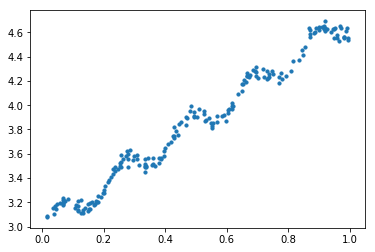

In [3]:
data = loadData('ex0.txt',sep='\t',header=None) #delimiter is Tab, no header
data = np.mat(data) #today, we utilize matrix type
xMat = data[:,0].T #column-wise
yMat = data[:,1]
fig = plt.figure()
plt.scatter(xMat.A[0], yMat.T.A[0], s=10)
plt.show()

Exercise 1: Complete the code for standard linear regression

In [4]:
def appendBias(X):
    return np.vstack((X, np.ones(X.shape[1])))

def standRegres(xArr,yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr)
    
    xTx = xMat*xMat.T
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    #ws = xTx.I * (xMat*yMat)  #We don't use inverse in practice.
    ws = np.linalg.solve(xTx, xMat*yMat)

    return ws

In [5]:
xMat_b = appendBias(xMat)  #xMat with bias 
w = standRegres(xMat_b,yMat)
print(w)

[[ 1.69532264]
 [ 3.00774324]]


In [6]:
yHat = w.T*xMat_b

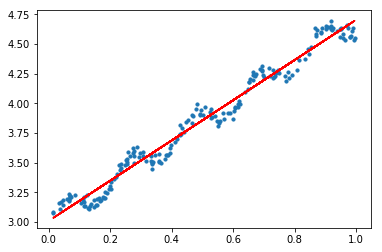

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat.flatten().A[0], yMat.T.flatten().A[0], s=10)
ax.plot(xMat.flatten().A[0], yHat.T.flatten().A[0], color='red')
plt.show()

In [8]:
#Bonus: comprare the time for inverse() and solve() (Ax=b)

import time

ndim=2000
A = np.mat(np.random.randn(ndim,ndim))
b = np.mat(np.random.randn(ndim,1))

start = time.time()
x1 = A.I*b
elapsed_time = time.time() - start
print ("inverse:{0}".format(elapsed_time) + "[sec]")

start = time.time()
x2 = np.linalg.solve(A,b)
elapsed_time = time.time() - start
print ("solve:{0}".format(elapsed_time) + "[sec]")

inverse:1.9618761539459229[sec]
solve:0.3989436626434326[sec]


Exercise 2: Complete the code for locally weighted linear regression

In [9]:
def locallyWeightedLR(testPoint,xArr,yArr,k=1.0):
    testPoint = np.mat(testPoint)
    xMat = np.mat(xArr)
    yMat = np.mat(yArr)
    m = np.shape(xMat)[1]
    weights = np.mat(np.eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[:,j]  
        weights[j,j] = np.exp(diffMat.T*diffMat/(-2.0*k**2))
    xTx = xMat * weights * xMat.T
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = np.linalg.solve(xTx, (xMat * weights * yMat))
    return ws

In [10]:
locallyWeightedLR(xMat_b[:,0],xMat_b,yMat,k=0.01) #test different value of k

matrix([[ 1.65398739],
        [ 3.09163874]])

In [11]:
def lwLRTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    m = np.shape(testArr)[1]
    testArr_b = appendBias(testArr)
    xArr_b = appendBias(xArr)
    yHat = np.zeros(m)
    for i in range(m):
        w = locallyWeightedLR(testArr_b[:,i],xArr_b,yArr,k)
        yHat[i] = w.T * np.mat(testArr_b[:,i])
    return yHat

In [12]:
yHat = lwLRTest(xMat,xMat,yMat,k=0.5)  

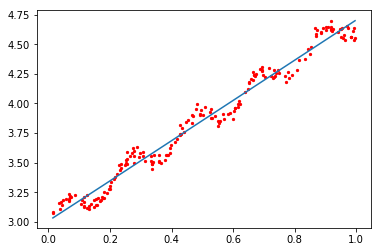

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
srtInd = xMat.A[0].argsort(0)
xSort = xMat[:,srtInd]
ax.plot(xSort.flatten().A[0],yHat[srtInd])
ax.scatter(xMat.flatten().A[0], yMat.T.flatten().A[0], s=5, c='red')
plt.show()


Now, let's consider generalization error.

In [14]:
def rssError(yArr,yHatArr): #yArr and yHatArr both need to be arrays
    return ((yArr-yHatArr)**2).sum()

First, evaluate error on training data.

In [15]:
data = loadData('abalone.txt',sep='\t', header=None)
xMat = np.mat(data[:,:8]).T
yMat = np.mat(data[:,8]).T

for k in [10,1,.5]:
    yHat=lwLRTest(xMat[:,:100],xMat[:,:100],yMat[:100],k)
    print('k={0}: {1}'.format(k, rssError(yMat[:100].T.A[0],yHat)))


k=10: 532.9037383272165
k=1: 411.97877254924856
k=0.5: 314.49778461048305


Ok, so how about testing data?

In [16]:
for k in [10,1,.5]:
    yHat=lwLRTest(xMat[:,100:200],xMat[:,:100],yMat[:100],k)    #テストデータを別にとる
    print('k={0}: {1}'.format(k, rssError(yMat[100:200].T.A[0],yHat)))


k=10: 609.9244790868446
k=1: 664.2491584972063
k=0.5: 744.0252058875878


Exercise 3: Complete the code for Ridge regression

In [17]:
def ridgeRegres(xArr,yArr, gamma):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr)
    
    xTx = xMat*xMat.T + gamma*np.eye(xMat.shape[0])
    if np.linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = np.linalg.solve(xTx, xMat*yMat)
    return ws

In [18]:
w=standRegres(xMat_b[:,:10],yMat[:10])
yHat=w.T*xMat_b[:,100:200]
print('linear regression: {0}'.format(rssError(yMat[100:200].T.A[0],yHat.T.A[0])))

linear regression: 1393.9179187510692


In [19]:
for gamma in [.001, .01, .1, 1,10,100]:
    w=ridgeRegres(xMat_b[:,:10],yMat[:10],gamma)
    yHat=w.T*xMat_b[:,100:200]
    print('Ridge regression, gamma={0}: {1}'.format(gamma, rssError(yMat[100:200].T.A[0],yHat.T.A[0])))


Ridge regression, gamma=0.001: 1393.6694607985069
Ridge regression, gamma=0.01: 1391.4543016530092
Ridge regression, gamma=0.1: 1371.2471722736207
Ridge regression, gamma=1: 1295.498807607054
Ridge regression, gamma=10: 3293.7041410959237
Ridge regression, gamma=100: 10433.838326679714


Let's see how coefficients shrink.

In [20]:
def ridgeTest(xArr,yArr):  #Loops ridgeRegress with different values of gamma.
    xMat = np.mat(xArr)
    yMat = np.mat(yArr)
    #regularize X's so that coefficient values are roughly normalized
    xMeans = np.mean(xMat,0)
    xStd = np.std(xMat,0)  
    xMat = (xMat - xMeans)/xStd
    numTestPts = 30
    wMat = np.zeros((numTestPts,np.shape(xMat)[0])) 
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))
        wMat[i,:]=ws.T
    return wMat

Now let's plot coefficents. Note that we ignore bias term here. The horizontal axis corresponds to log(gamma).

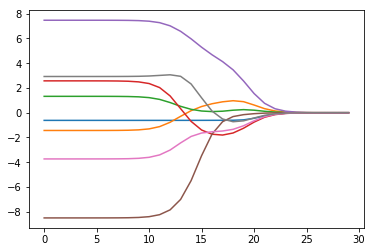

In [21]:
ridgeWeights = ridgeTest(xMat,yMat)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.show()